In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import jj
from scipy.signal import argrelextrema

### Connecting Neurons
The next step in creating a Spiking Neural Network is to be able to connect two neurons together. If we connect the neurons as presented in the [circuit](https://github.com/ubsuny/Josephson_Junction_Neuromorphic-Raspi4-/blob/87b64adf961712c6d819b1c553c51c26f8a4b849/Circuit.png) discussed. According to the paper by Crotty$^{[2]}$, the connection between the neurons can be defined by a set of coupled differential equations:
$\frac{1}{\Omega_0^2}\ddot{v}_{out}+\frac{Q}{\Omega_0}\dot{v}_{out}+v_{out}=v_p-\frac{Q \Omega_0 \Lambda_{syn}}{\lambda}i_{12} - \frac{\Lambda_{syn}}{lambda}\dot{i}_{12}$  

$\frac{\Lambda_{syn}(1-\Lambda_{syn})}{\lambda}\dot{i}_{12}+\frac{r_{12}}{\Gamma}i_{12}=v_{out}-\Lambda_{syn}(v_{c2}+v_{p2})$  

$\Omega_0 = 1.0, Q = 0.05, \Lambda_{syn} = 0.3, r_{12} = 1.4$, other parameters are the same, save for $i_b = 2.0, \Gamma = 2.0$


This gives both the output voltage and the input voltage based on the output voltage. This means it is now possible to adjust the input current to the neuron based on the voltage output.

In [ ]:
## Time domain set up
time = 300 # Final Time
n = 20000 # Resolution
dt = time / n # A single time step length
tspan = np.arange(0, time, dt)  # time span
ispan = np.zeros_like(tspan)  # input current span

## First Neuron
phi_c = np.zeros_like(tspan)
v_c = np.zeros_like(tspan)

phi_p = np.zeros_like(tspan)
v_p = np.zeros_like(tspan)

## Second Neuron
phi_2c = np.zeros_like(tspan)
v_2c = np.zeros_like(tspan)

phi_2p = np.zeros_like(tspan)
v_2p = np.zeros_like(tspan)


## System Parameters
lmda = 0.1
gamma = 2.0
lmda_s = 0.5
lmda_p = 0.5
eta = 1
i_in = 0.3
i_b = 2.0

## Synapse parameters
Q = 0.05
lmda_syn = 0.3
r12 = 1.4
omega = 1.0

## Define input current
ispan[int(np.size(ispan)/4):int(3*np.size(ispan)/4)] = i_in

In [ ]:
## Initial Conditions, Nueron 1
phi_p[0] = 0
v_p[0] = 0
phi_c[0] = 0
v_c[0] = 0
i_p = -lmda*(phi_c[0] + phi_p[0]) + lmda_s*ispan[0] + (1-lmda_p)*i_b
i_c = (-lmda*(phi_c[0] + phi_p[0]) + lmda_s*ispan[0] - lmda_p*i_b)/eta

## Initial Conditions, Synapse
i_o = 0
id_o = 0
v_o = 0
vd_o = 0

## Initial Conditions, Neuron 2
phi_2p[0] = 0
v_2p[0] = 0
phi_2c[0] = 0
v_2c[0] = 0
i_2p = -lmda*(phi_2c[0] + phi_2p[0]) + lmda_s*i_o + (1-lmda_p)*i_b
i_2c = (-lmda*(phi_2c[0] + phi_2p[0]) + lmda_s*i_o - lmda_p*i_b)/eta

In [21]:
## Operate the Circuit
for j in range(np.size(tspan)-1):
    ## First Neuron
    phi_p[j+1], v_p[j+1] = jj.junction_step(phi_p[j], v_p[j], dt, gamma, i_p)
    phi_c[j+1], v_c[j+1] = jj.junction_step(phi_c[j], v_c[j], dt, gamma, i_c)
    i_p = -lmda*(phi_c[j+1] + phi_p[j+1]) + lmda_s*ispan[j+1] + (1-lmda_p)*i_b
    i_c = (-lmda*(phi_c[j+1] + phi_p[j+1]) + lmda_s*ispan[j+1] - lmda_p*i_b)/eta
    
    ## Output to Second Neuron
    [i_o, id_o, v_o, vd_o] = jj.synapse_step(v_o, vd_o, i_o, id_o, v_p[j], v_2c[j], v_2p[j], gamma, omega, Q, lmda, lmda_syn, r12, dt)
    
    ## Second Neuron
    phi_2p[j+1], v_2p[j+1] = jj.junction_step(phi_2p[j], v_2p[j], dt, gamma, i_2p)
    phi_2c[j+1], v_2c[j+1] = jj.junction_step(phi_2c[j], v_2c[j], dt, gamma, i_2c)
    i_2p = -lmda*(phi_2c[j+1] + phi_2p[j+1]) + lmda_s*i_o + (1-lmda_p)*i_b
    i_2c = (-lmda*(phi_2c[j+1] + phi_2p[j+1]) + lmda_s*i_o - lmda_p*i_b)/eta    
    
flux = lmda*(phi_p+phi_c)
flux_2 = lmda*(phi_2p + phi_2c)
maxima = argrelextrema(flux,np.greater)
spikes = maxima[0].size

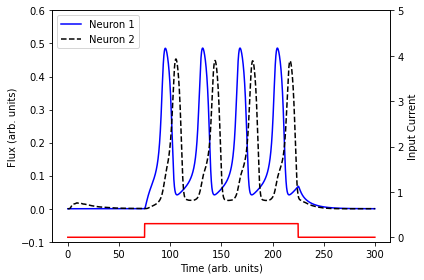

In [27]:
## Plotting
fig, ax1 = plt.subplots()

fig.patch.set_facecolor('white')

ax1.set_xlabel('Time (arb. units)')
ax1.set_ylabel('Flux (arb. units)')
ax1.plot(tspan,flux, 'b')
ax1.plot(tspan,flux_2,'k--')
# ax1.set_xlim(50,250)
ax1.set_ylim(-0.1,0.6)
ax1.legend(["Neuron 1","Neuron 2"],loc='upper left')

ax2 = ax1.twinx()
ax2.plot(tspan,ispan, 'r')
ax2.set_ylim(-0.1,5)
ax2.set_ylabel('Input Current')

fig.tight_layout()
plt.show()

Here we can see the one neuron driving the other neuron based of of an input current. When the current drops to 0, there is no firing of either neuron.

### Fitting the Sigmoid Function Method
It is possible to fit the phase relation of the Josephson Junction to the sigmoid function used for the simple neural network to create a direct analogy with the artificial neural network. This can be done by adding a linear term near $\varphi \approx sin(\varphi)$ in the regime of $\phi_{in} \approx 0$. This would allow a direct replacement of the sigmoid function in the basic model I created, which show the ability of the junction to be uses as a neural network.

Note, time depending I may only be able to realize one of these methods, but would act as further potential work to be done.